In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoLarsIC
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import cross_val_score

In [2]:
from auxiliary_files.auxiliary_data import *

# Data Application

The data in this examples comes originally from a study by Stamey et al (1989) that examined the correlation between the level of prostate specific antigen (PSA) and several number of clinical measures for 97 men who were about to receive prostatectomy.

The goal of the exercise is to predict the log of PSA from a number of measurements including log cancer volume (lcavol), log prostate weight lweight, age, log of benign prostatic hyperplasia amount lbph, seminal vesicle invasion svi, log of capsular penetration lcp, Gleason score gleason, and percent of Gleason scores 4 or 5 pgg45.

In [3]:
raw_data = pd.read_csv('prostate_dataset.txt', delimiter='\t')

In [4]:
raw_data

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
92,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [11]:
raw_data.shape

(97, 11)

In [12]:
raw_data.isnull().sum()

col        0
lcavol     0
lweight    0
age        0
lbph       0
svi        0
lcp        0
gleason    0
pgg45      0
lpsa       0
train      0
dtype: int64

In [13]:
raw_data.iloc[:,1:-1].describe().round(2)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00
mean,1.35,3.63,63.87,0.10,0.22,-0.18,6.75,24.38,2.48
std,1.18,0.43,7.45,1.45,0.41,1.40,0.72,28.20,1.15
min,-1.35,2.37,41.00,-1.39,0.00,-1.39,6.00,0.00,-0.43
25%,0.51,3.38,60.00,-1.39,0.00,-1.39,6.00,0.00,1.73
50%,1.45,3.62,65.00,0.30,0.00,-0.80,7.00,15.00,2.59
75%,2.13,3.88,68.00,1.56,0.00,1.18,7.00,40.00,3.06
max,3.82,4.78,79.00,2.33,1.00,2.90,9.00,100.00,5.58


In [4]:
X = raw_data.iloc[:,1:-2]
y = raw_data.iloc[:,9]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [5]:
#X_train = raw_data.iloc[:,1:-2][raw_data['train']=='T'] #not scaled
X_train = X_scaled[raw_data['train']=='T']
y_train = raw_data.iloc[:,9][raw_data['train']=='T']
#X_test = raw_data.iloc[:,1:-2][raw_data['train']=='F'] #not scaled
X_test = X_scaled[raw_data['train']=='F']
y_test = raw_data.iloc[:,9][raw_data['train']=='F']

In [5]:
X_train.shape
X_test.shape

(30, 8)

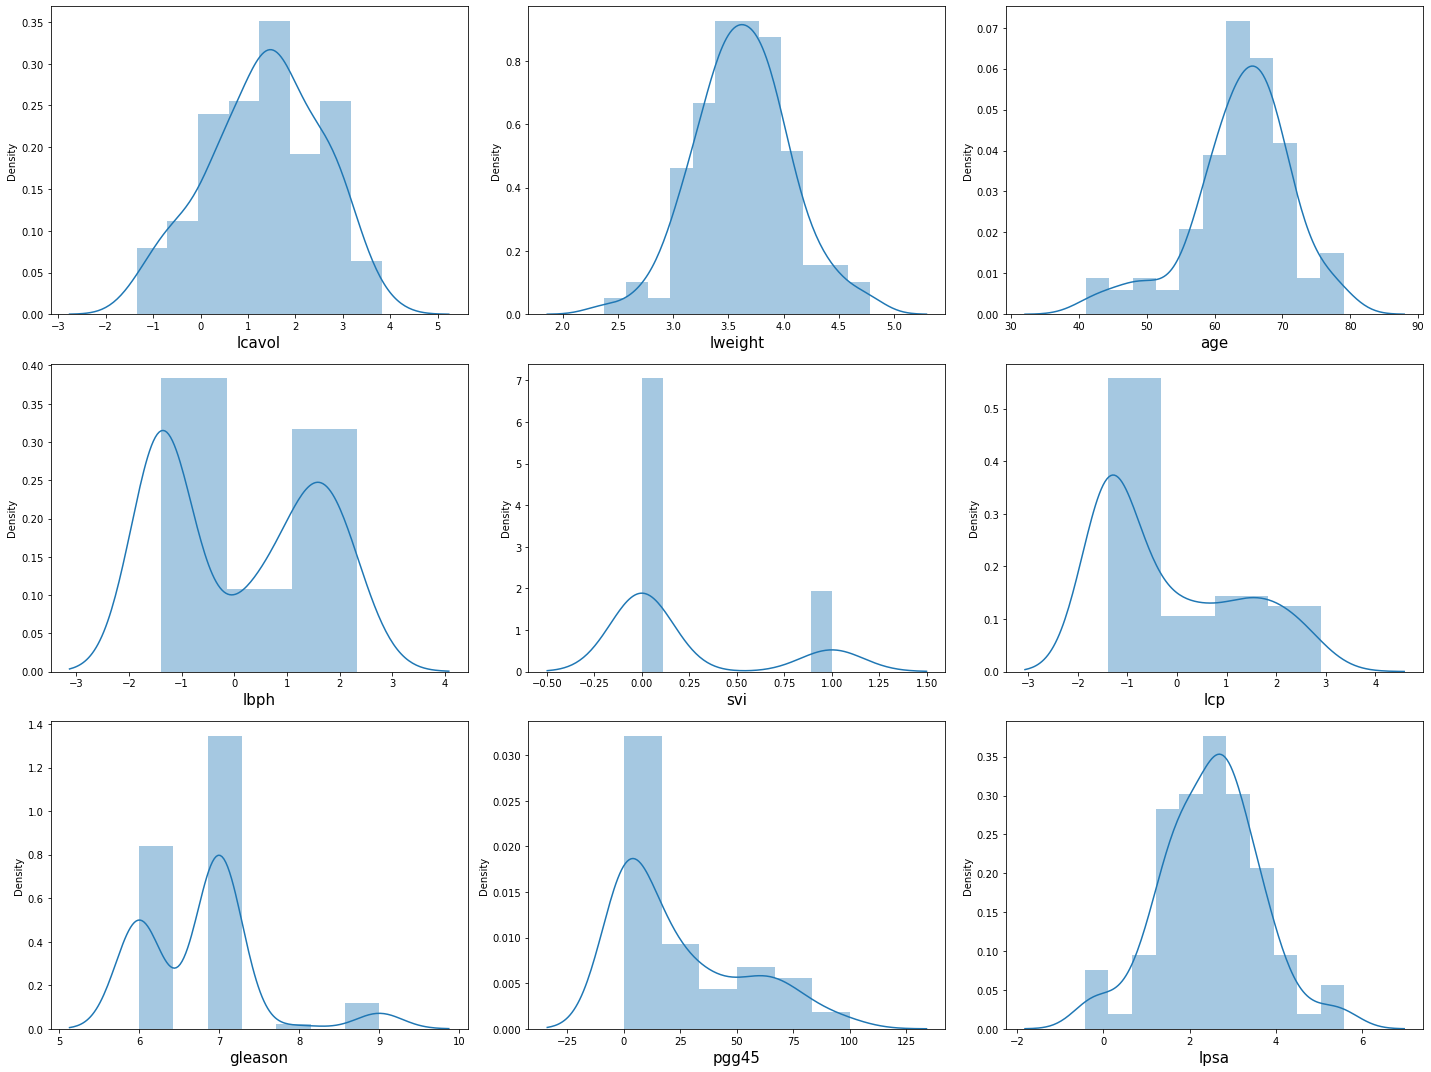

In [6]:
fig = plt.figure(figsize = (20, 15))
plotnumber = 1

for column in raw_data.iloc[:,1:-1]:
    if plotnumber <= 9:
        ax = plt.subplot(3, 3, plotnumber)
        sns.distplot(raw_data.iloc[:,1:-1][column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()
fig.savefig('vardistr.png', dpi=fig.dpi, bbox_inches='tight')

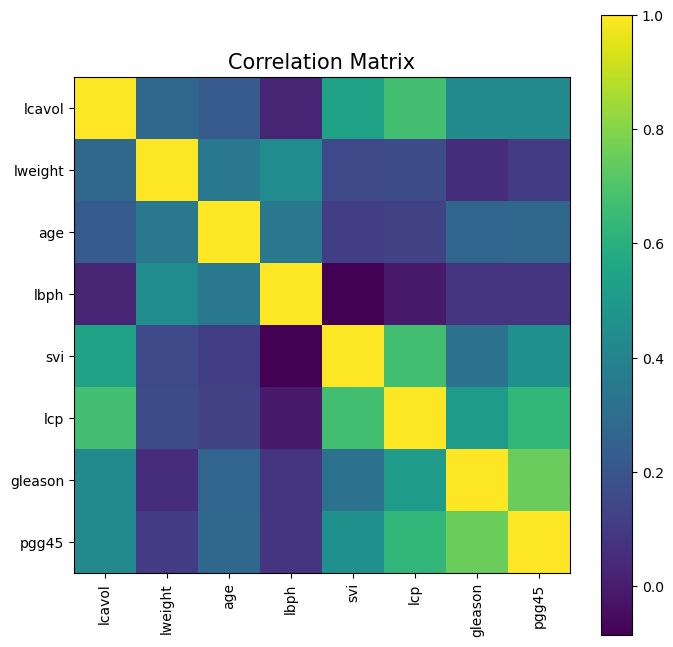

In [6]:
# Correlation matrix
correlation_matrix(X_scaled)

#from the plot below we can see that
#-->there is some correlation among regressors. E.g. gleason and pgg45 are correlated, indeed, the variable pgg45 measures the percentage of 4 or 5 Gleason scores that were recorded before the final current Gleason score

Below: Replication of scatterplot matrix of the prostate cancer in Elements of Statistical Learning, pg. 3. The predictors svi and gleason are categorical. 

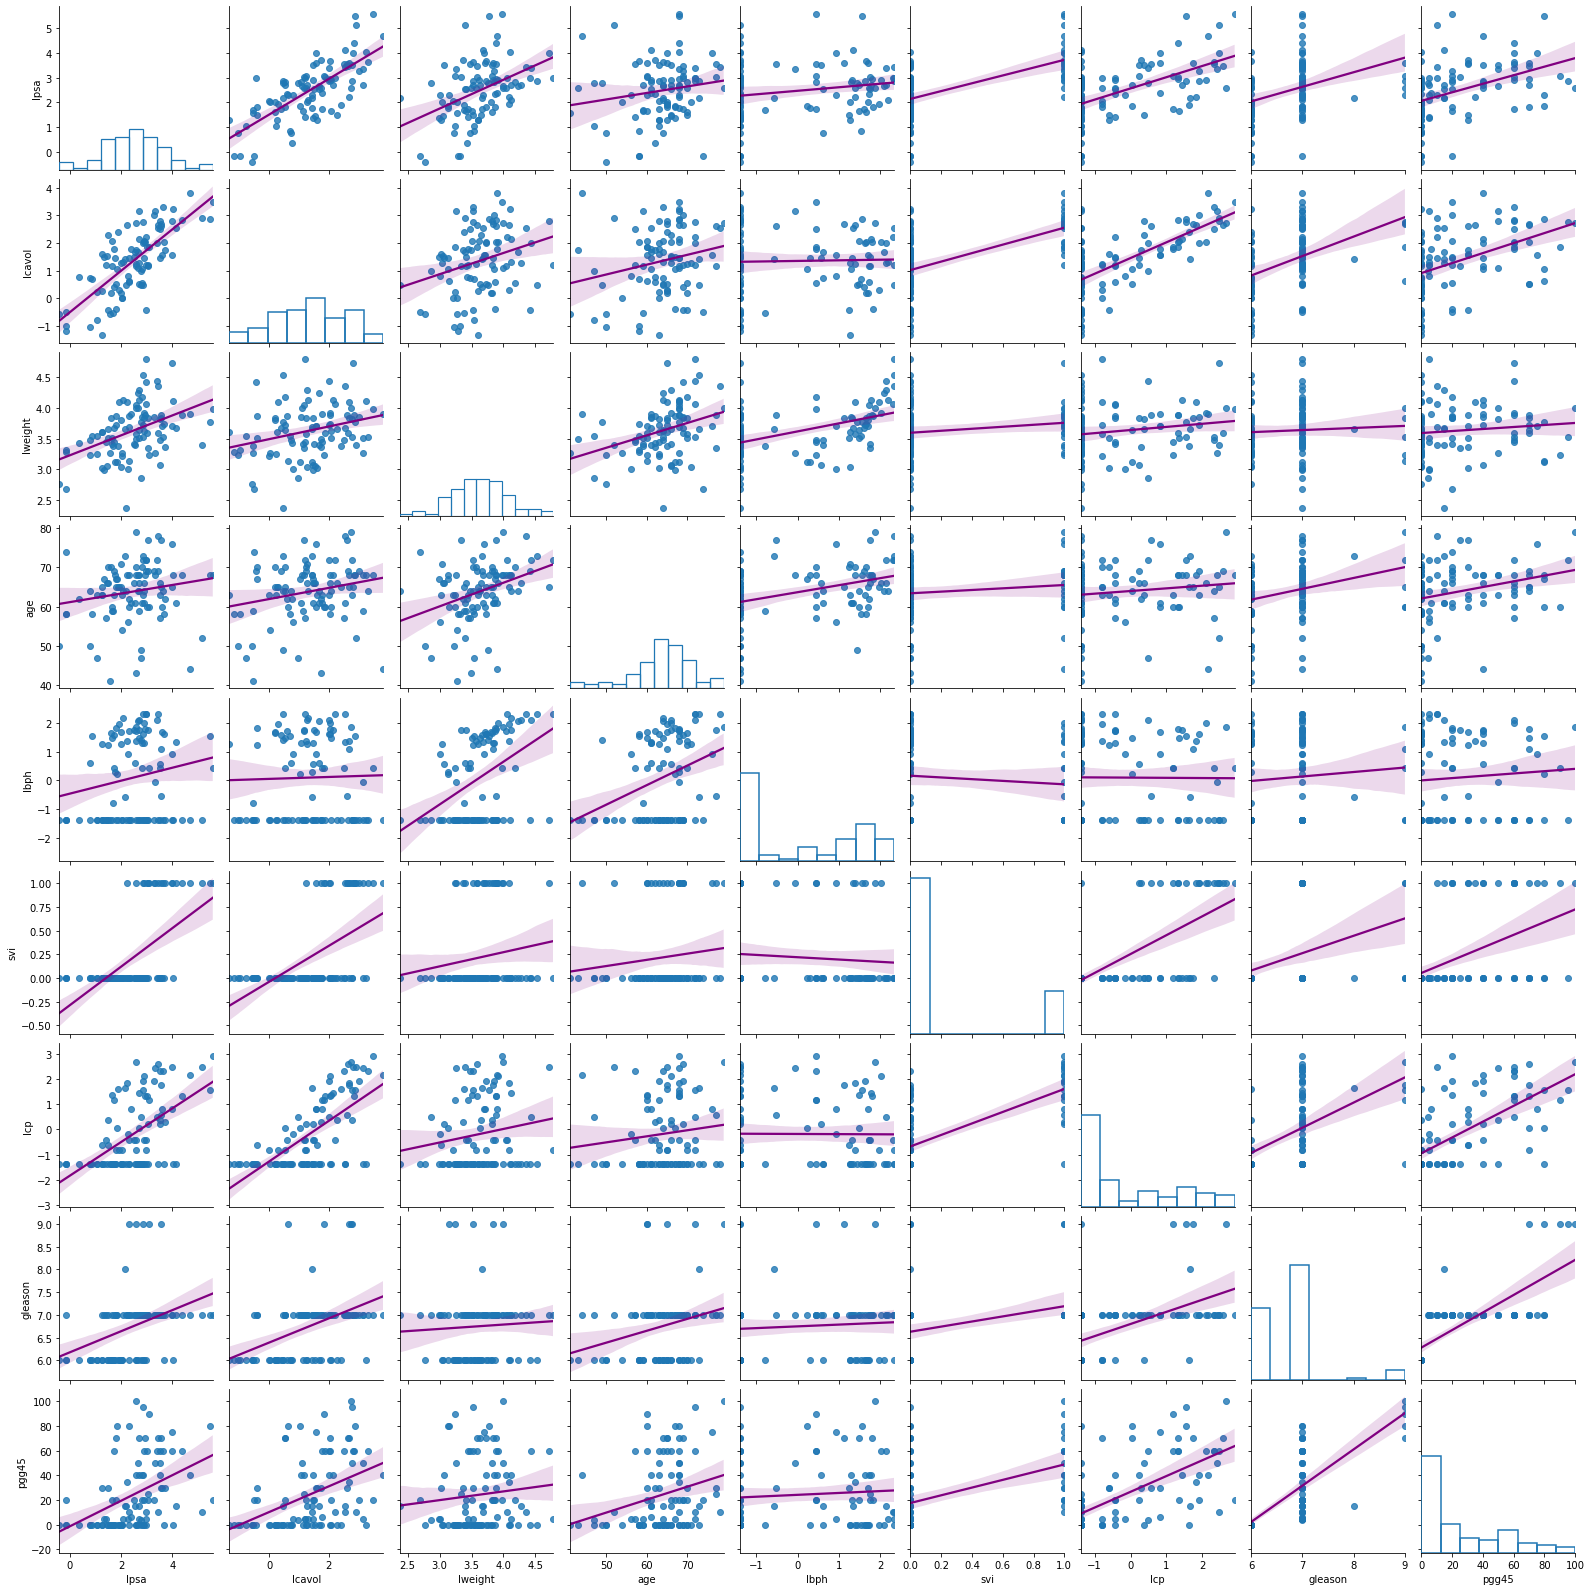

In [10]:
sns.pairplot(
    data=raw_data[['lpsa','lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']],
    #plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
    kind="reg", 
    plot_kws={'line_kws':{'color':'purple'}}
)
plt.savefig('pairplot.png')

In [12]:
corr = raw_data[['lpsa','lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']].corr()
corr.style.background_gradient(cmap='coolwarm')

,lpsa,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lpsa,1.000000,0.734460,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316
lcavol,0.734460,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652
lweight,0.433319,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354
age,0.169593,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112
lbph,0.179809,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460
svi,0.566218,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648
lcp,0.548813,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528
gleason,0.368987,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905
pgg45,0.422316,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000


Variables that show strong correlation (not against lpsa):
- lcp and lcavol
- svi and lcp
- pgg45 and gleason
- pgg45 and lcp

# Linear regression baseline

In [15]:
# Linear regression model
lr = linear_model.LinearRegression()
# learn the model on the train set
lm_reg=lr.fit(X_train,y_train)
# baseline error
y_pred = lr.predict(X_test)
baseline_error = np.mean((y_pred - y_test) ** 2)
print("Linear regression error: %0.4f" % baseline_error)

Linear regression error: 0.5213


Coefficients of the regression (the same as in ESL, pg.50)

In [16]:
table_coefficients(lm_reg.coef_, 3)

,Term,Coefficient
0,lcavol,0.676
1,lweight,0.262
2,age,-0.141
3,lbph,0.209
4,svi,0.304
5,lcp,-0.287
6,gleason,-0.021
7,pgg45,0.266


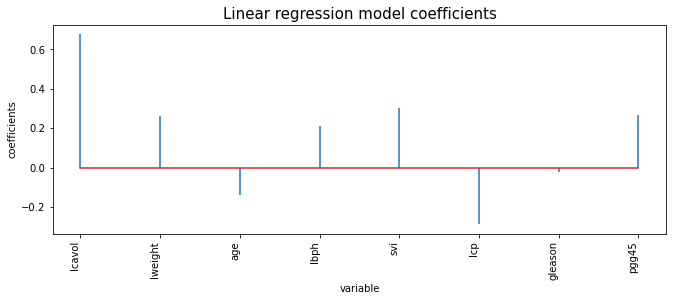

In [17]:
plot_model_coefficients(X_train, lm_reg.coef_, "Linear regression")

# Ridge regression

To avoid overfitting, ridge regression has a grouped selection effect: the correlated variables have the same weights.

In [7]:
n_alphas = 300
alphas = np.logspace(-6, 6, n_alphas)

In [18]:
#n_alphas = 100
#alphas = np.logspace(-4, 3, n_alphas)
coef_ridge = []
err_ridge = []
baseline = []
for a in alphas:
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    coef_ridge.append(ridge.coef_)
    y_pred = ridge.predict(X_test)
    ridge_error = np.mean((y_pred - y_test) ** 2)
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [19]:
ridge_cv = RidgeCV(alphas = alphas, cv = 10)
ridge_cv.fit(X_train, y_train)
alpha = ridge_cv.alpha_
alpha#is different from the minimum found below (?)##############
ridge = Ridge(alpha = alpha)
ridge.fit(X_train, y_train)
pred_err_ridge_cv = np.mean((ridge.predict(X_test) - y_test) ** 2)
print(ridge)
print(pred_err_ridge_cv)

Ridge(alpha=42.21026320156903)
0.5045813935527431


In [76]:
#we use GridSearchCV to tune the hyperparameter because it uses MSE as scoring method
ridge = Ridge()
grid = dict()
grid['alpha'] = alphas
gscv = GridSearchCV(ridge, grid, scoring='neg_mean_squared_error', cv=10)
gscv.fit(X_train, y_train)
alpha_ridge = gscv.best_params_
print(alpha_ridge)
y_pred = gscv.predict(X_test)
pred_err_ridge_gs = np.mean((y_pred - y_test) ** 2)
print(pred_err_ridge_gs)

{'alpha': 2.4058630546440667}
0.5039812978160961


In [ ]:
ridge_coef = gscv.best_estimator_.coef_

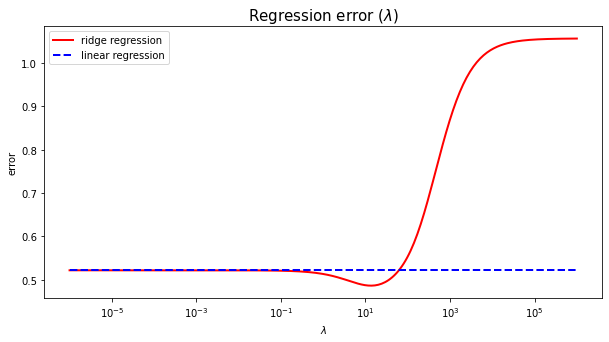

In [9]:
plot_regression_error(alphas, err_ridge, baseline, 'ridge', 'linear')

In [65]:
#min(err_ridge)

In [66]:
#alphas[np.argmin(err_ridge)]

In [9]:
train_scores, val_scores = validation_curve(Ridge(),
                                  X_train, y_train, param_name="alpha", param_range=alphas,
                                  cv=10, scoring='neg_mean_squared_error')
train_scores = -(train_scores)
val_scores = -(val_scores)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

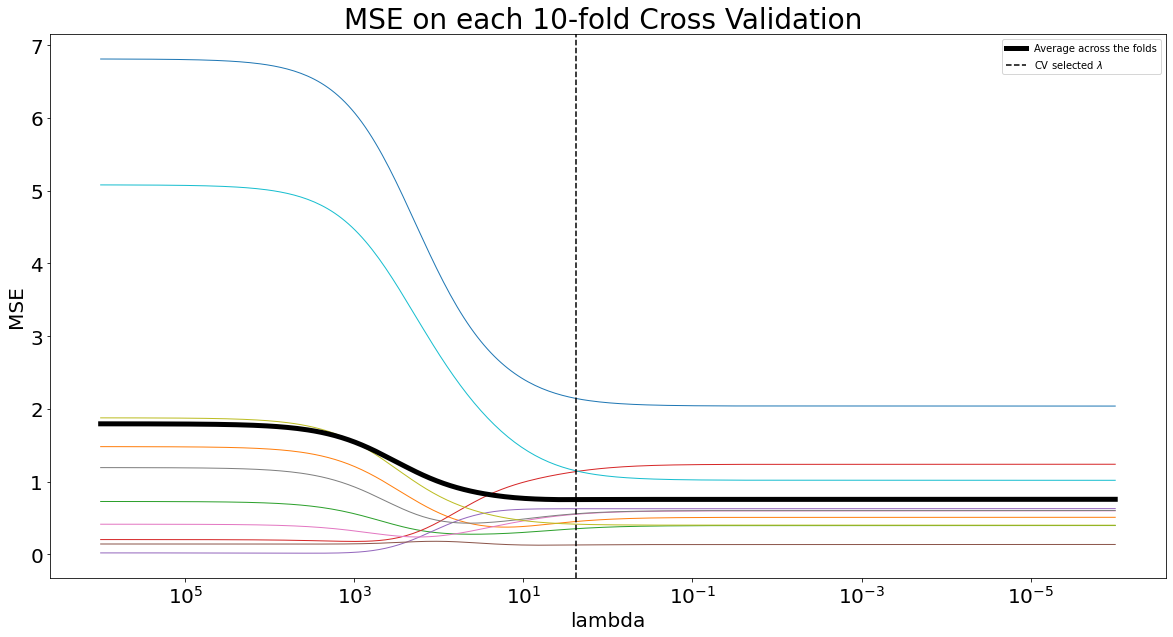

In [11]:
plot_CV(alphas, val_scores, val_mean)

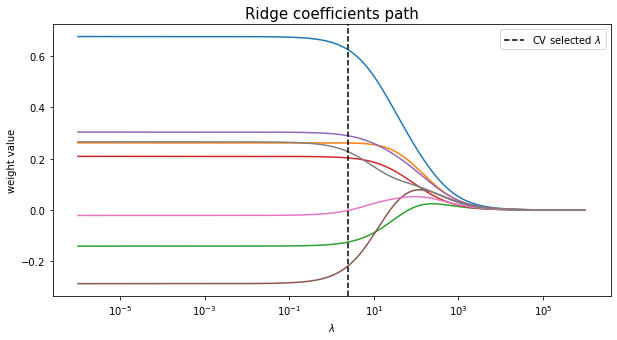

In [10]:
plot_paths(alphas, val_mean, coef_ridge, 'Ridge')

In [23]:
table_coefficients(ridge_coef, 3)

,Term,Coefficient
0,lcavol,0.624
1,lweight,0.261
2,age,-0.125
3,lbph,0.203
4,svi,0.289
5,lcp,-0.216
6,gleason,-0.001
7,pgg45,0.226


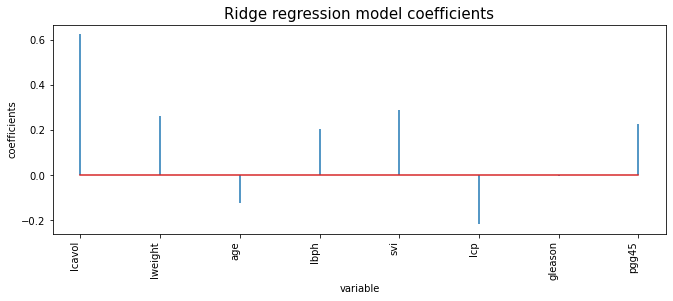

In [24]:
plot_model_coefficients(X_train, ridge_coef, "Ridge regression")

# Lasso regression

The Lasso performs a model's feature selection: for correlated variables, it retains only one variable and sets other correlated variables to zero. The counterpart is that it obviously induces a loss of information resulting in lower accuracy.

In [25]:
coef_lasso = []
err_lasso = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = np.mean((y_pred - y_test) ** 2)
    err_lasso.append(lasso_error)

## Trying different methods for obtaining alpha in the lasso

### 10 fold cross-validation

In [22]:
lasso_cv = LassoCV(alphas = alphas, cv = 10, max_iter = 10000)
lasso_cv.fit(X_train, y_train)
alpha = lasso_cv.alpha_
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train, y_train)
pred_err_lasso_cv = np.mean((lasso.predict(X_test) - y_test) ** 2)
print(lasso)
print(pred_err_lasso_cv)

Lasso(alpha=0.0037316968377327556)
0.5107822709723145


In [12]:
train_scores, val_scores = validation_curve(Lasso(),
                                  X_train, y_train, param_name="alpha", param_range=alphas,
                                  cv=10, scoring='neg_mean_squared_error')
train_scores = -(train_scores)
val_scores = -(val_scores)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

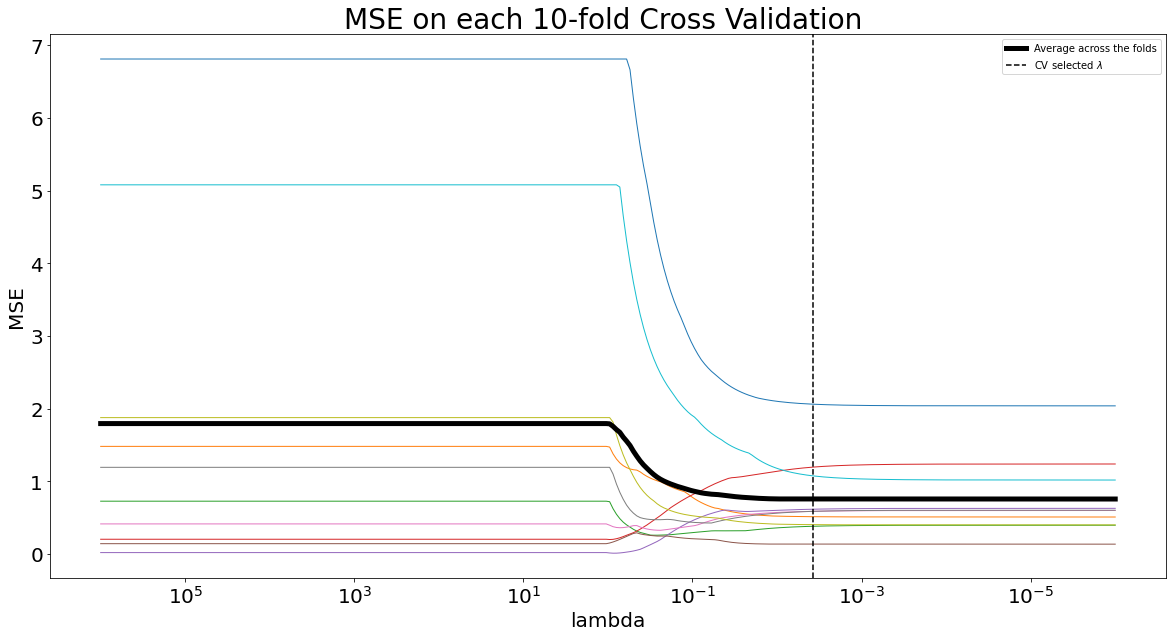

In [19]:
plot_CV(alphas, val_scores, val_mean)

In [41]:
alphas[np.argmin(val_mean)]

0.0037316968377327556

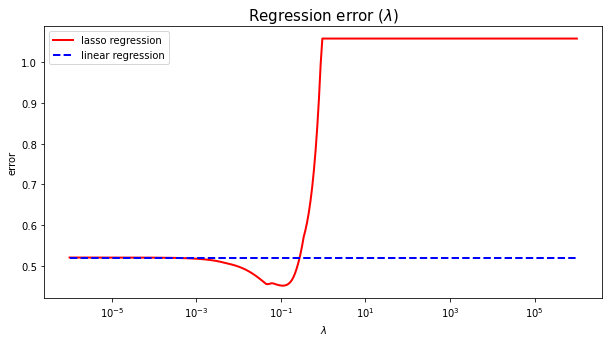

In [12]:
plot_regression_error(alphas, err_lasso, baseline, 'lasso', 'linear')

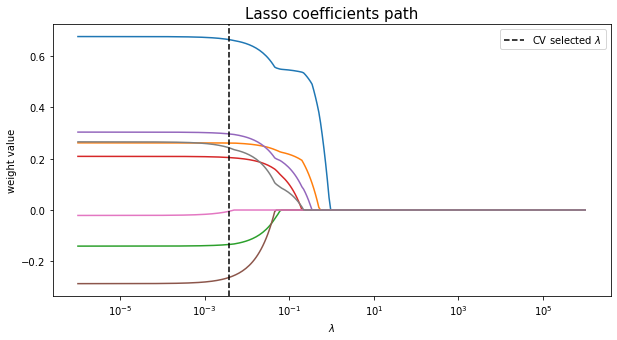

In [13]:
plot_paths(alphas, val_mean, coef_lasso, 'Lasso')

### Grid search (another method for cross validation)

In [50]:
lasso = Lasso()
grid = dict()
grid['alpha'] = alphas
gscv = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error', cv=10)
gscv.fit(X_train, y_train)
alpha_lasso = gscv.best_params_
print(alpha_lasso)
y_pred = gscv.predict(X_test)
pred_err_lasso_gs = np.mean((y_pred - y_test) ** 2)
print(pred_err_lasso_gs)

{'alpha': 0.0037316968377327556}
0.5107822709723145


In [49]:
gscv.best_params_

{'alpha': 0.0037316968377327556}

In [28]:
lasso_coeff = gscv.best_estimator_.coef_

In [29]:
table_coefficients(lasso_coeff, 3)

,Term,Coefficient
0,lcavol,0.664
1,lweight,0.261
2,age,-0.134
3,lbph,0.205
4,svi,0.297
5,lcp,-0.263
6,gleason,-0.005
7,pgg45,0.243


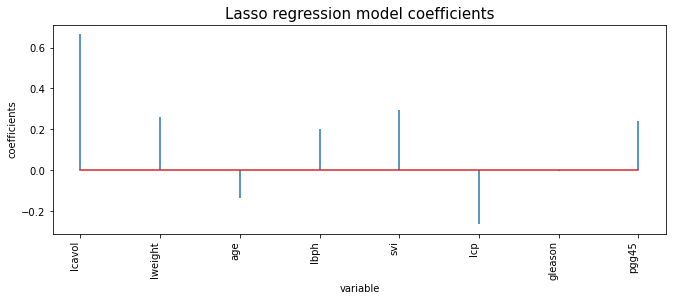

In [30]:
plot_model_coefficients(X_train, lasso_coeff, "Lasso regression")

### AIC and BIC information criteria

The estimator LassoLarsIC proposes to use the Akaike information criterion (AIC) and the Bayes Information criterion (BIC). It is a computationally cheaper alternative to find the optimal value of alpha as the regularization path is computed only once instead of k+1 times when using k-fold cross-validation.

Model selection with an information-criterion is very fast. It relies on computing the criterion on the in-sample set provided to fit. Both criteria estimate the model generalization error based on the training set error and penalize this overly optimistic error. However, this penalty relies on a proper estimation of the degrees of freedom and the noise variance. Both are derived for large samples (asymptotic results) and assume the model is correct, i.e. that the data are actually generated by this model.

In [40]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_train, y_train)
alpha_bic_ = model_bic.alpha_
alpha_bic_

0.02582845420384153

In [47]:
pred_err_lassoLARS_bic = np.mean((model_bic.predict(X_test) - y_test) ** 2)
print(pred_err_lasso_bic)

0.4760666450941409


In [41]:
lassoLARS_bic_coeff = model_bic.coef_

In [42]:
table_coefficients(lassoLARS_bic_coeff, 3)

,Term,Coefficient
0,lcavol,0.529
1,lweight,0.168
2,age,0.000
3,lbph,0.000
4,svi,0.091
5,lcp,0.000
6,gleason,0.000
7,pgg45,0.000


In [32]:
model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_
alpha_aic_ 

0.007362933717076799

In [46]:
pred_err_lassoLARS_aic = np.mean((model_aic.predict(X_test) - y_test) ** 2)
print(pred_err_lasso_aic)

0.5033421105166255


In [43]:
lassoLARS_aic_coeff = model_aic.coef_

In [44]:
table_coefficients(lassoLARS_aic_coeff, 3) #this yields the same VARIABLES SELECTION as in Zou&Hastie

,Term,Coefficient
0,lcavol,0.547
1,lweight,0.220
2,age,0.000
3,lbph,0.142
4,svi,0.196
5,lcp,0.000
6,gleason,0.000
7,pgg45,0.086


In [42]:
def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='lambda: %s estimate' % name)
    plt.xlabel(r'$\lambda$')
    plt.ylabel('criterion')

Text(0.5, 1.0, 'Information-criterion for model selection')

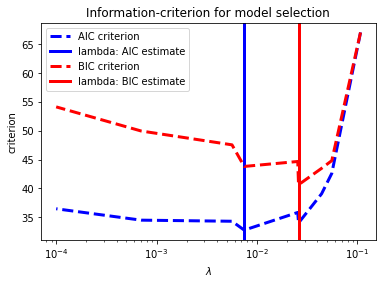

In [43]:
EPSILON = 1e-4 #to avoid division get zero
plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection')

In [33]:
lasso_bic = Lasso(alpha = model_bic.alpha_)
lasso_bic.fit(X_train, y_train)
pred_err_lasso_bic = np.mean((lasso_bic.predict(X_test) - y_test) ** 2)
print(lasso_bic)
print(pred_err_lasso_bic)

Lasso(alpha=0.02582845420384153)
0.4760666450941409


In [36]:
lasso_bic_coeff = lasso_bic.coef_

In [37]:
table_coefficients(lasso_bic_coeff, 3)

,Term,Coefficient
0,lcavol,0.607
1,lweight,0.248
2,age,-0.082
3,lbph,0.180
4,svi,0.247
5,lcp,-0.126
6,gleason,0.000
7,pgg45,0.168


In [35]:
lasso_aic = Lasso(alpha = model_aic.alpha_)
lasso_aic.fit(X_train, y_train)
pred_err_lasso_aic = np.mean((lasso_aic.predict(X_test) - y_test) ** 2)
print(lasso_aic)
print(pred_err_lasso_aic)

Lasso(alpha=0.007362933717076799)
0.5033421105166255


In [38]:
lasso_aic_coeff = lasso_aic.coef_

In [39]:
table_coefficients(lasso_aic_coeff, 3)

,Term,Coefficient
0,lcavol,0.654
1,lweight,0.259
2,age,-0.126
3,lbph,0.200
4,svi,0.289
5,lcp,-0.240
6,gleason,-0.000
7,pgg45,0.227


## LARS algorithm

In [45]:
from sklearn.linear_model import LassoLarsCV

In [46]:
lasso_lars_cv = LassoLarsCV(cv = 10, normalize = False).fit(X_train, y_train)
lasso_lars_cv.alpha_

0.004582700457631942

In [47]:
lasso_lars = Lasso(alpha = lasso_lars_cv.alpha_)
lasso_lars.fit(X_train, y_train)
pred_err_lasso_lars = np.mean((lasso_lars.predict(X_test) - y_test) ** 2)
print(lasso_lars)
print(pred_err_lasso_lars)

Lasso(alpha=0.004582700457631942)
0.5084922857747898


In [41]:
min(err_lasso)

0.4524744740963335

In [42]:
alphas[np.argmin(err_lasso)]

0.10974987654930557

# Elastic Net regression

Elastic Net overcomes the issue of losing information. It has a selecting effect on variables as Lasso but keep correlated variables as Ridge regression. Thus the Elastic net model is less sparse than the Lasso, keeping more information.

In [14]:
coef_eln = []
err_eln = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=0.5)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = np.mean((y_pred - y_test) ** 2)
    err_eln.append(elasticnet_error)

In [9]:
ratios = np.linspace(0, 1, 40)

In [49]:
elnet_cv = ElasticNetCV(alphas = alphas, l1_ratio = ratios, cv = 10, max_iter = 100000)
elnet_cv.fit(X_train, y_train)
alpha = elnet_cv.alpha_
ratio = elnet_cv.l1_ratio_
alpha
ratio
elnet = ElasticNet(alpha = alpha, l1_ratio = ratio)
elnet.fit(X_train, y_train)
pred_err_elnet_cv = np.mean((elnet.predict(X_test) - y_test) ** 2)
print(elnet)
print(pred_err_elnet_cv)

ElasticNet(alpha=0.03760545399658176, l1_ratio=0.0)
0.5034016618061022


In [51]:
eln_coeff = elnet.coef_ #from ElasticNetCV()

In [14]:
eln_coeff = gscv.best_estimator_.coef_#from GridSearchCV()
eln_coeff

array([ 0.62355024,  0.26118846, -0.12465789,  0.20293258,  0.28916407,
       -0.2164602 , -0.00126484,  0.22640882])

In [78]:
# elnet_robust_betas = (1 + alpha_ridge['alpha']) * eln_coeff

array([ 2.12372672,  0.88957214, -0.42456769,  0.69116056,  0.98485321,
       -0.7372338 , -0.00430788,  0.77111744])

In [10]:
elnet = ElasticNet()
grid = dict()
grid['alpha'] = alphas
grid['l1_ratio'] = ratios
gscv = GridSearchCV(elnet, grid, scoring='neg_mean_squared_error', cv=10)
gscv.fit(X_tra0..in, y_train)
print(gscv.best_params_)
y_pred = gscv.predict(X_test)
pred_err_elnet_gs = np.mean((y_pred - y_test) ** 2)
print(pred_err_elnet_gs)

{'alpha': 0.03760545399658176, 'l1_ratio': 0.0}
0.5034016618061017


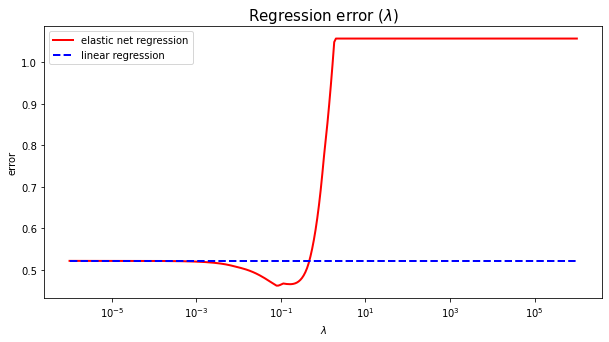

In [15]:
plot_regression_error(alphas, err_eln, baseline, 'elastic net', 'linear')

In [39]:
'''
fig, (ax1, ax2, ax3) = plt.figure(figsize=(8,4)).subplots(3)
fig.suptitle(r'Regression error ($\lambda$)')
#fig.figure(figsize=(8,4))
#ax1 = plt.gca()
ax1.plot(alphas, err_ridge, linewidth=2, color='red', label='Ridge regression')
ax1.plot(alphas, baseline, linewidth=2, linestyle='--', color='blue', label='linear regression')
ax1.set_xscale('log')
#plt.xlabel('$\lambda$', fontsize=25)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.ylabel('error', fontsize=20)
ax1.legend(fontsize=15)
#plt.title(r'Regression error ($\lambda$)', fontsize=25)
#plt.figure(figsize=(8,4))
#ax2 = plt.gca()
ax2.plot(alphas, err_lasso, linewidth=2, color='red', label='Lasso regression')
ax2.plot(alphas, baseline, linewidth=2, linestyle='--', color='blue', label='linear regression')
ax2.set_xscale('log')
#plt.xlabel('$\lambda$', fontsize=25)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.ylabel('error', fontsize=20)
ax2.legend(fontsize=15)
#plt.title(r'Regression error ($\lambda$)', fontsize=25)
#plt.figure(figsize=(8,4))
#ax3 = plt.gca()
ax3.plot(alphas, err_eln, linewidth=2, color='red', label='Elastic net regression')
ax3.plot(alphas, baseline, linewidth=2, linestyle='--', color='blue', label='linear regression')
ax3.set_xscale('log')
#plt.xlabel('$\lambda$', fontsize=25)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.ylabel('error', fontsize=20)
ax3.legend(fontsize=15)
#plt.title(r'Regression error ($\lambda$)', fontsize=25)
fig.savefig('err_vs_lambda.png', dpi=fig.dpi, bbox_inches='tight')
'''

"\nfig, (ax1, ax2, ax3) = plt.figure(figsize=(8,4)).subplots(3)\nfig.suptitle(r'Regression error ($\\lambda$)')\n#fig.figure(figsize=(8,4))\n#ax1 = plt.gca()\nax1.plot(alphas, err_ridge, linewidth=2, color='red', label='Ridge regression')\nax1.plot(alphas, baseline, linewidth=2, linestyle='--', color='blue', label='linear regression')\nax1.set_xscale('log')\n#plt.xlabel('$\\lambda$', fontsize=25)\n#plt.xticks(fontsize=20)\n#plt.yticks(fontsize=20)\n#plt.ylabel('error', fontsize=20)\nax1.legend(fontsize=15)\n#plt.title(r'Regression error ($\\lambda$)', fontsize=25)\n#plt.figure(figsize=(8,4))\n#ax2 = plt.gca()\nax2.plot(alphas, err_lasso, linewidth=2, color='red', label='Lasso regression')\nax2.plot(alphas, baseline, linewidth=2, linestyle='--', color='blue', label='linear regression')\nax2.set_xscale('log')\n#plt.xlabel('$\\lambda$', fontsize=25)\n#plt.xticks(fontsize=20)\n#plt.yticks(fontsize=20)\n#plt.ylabel('error', fontsize=20)\nax2.legend(fontsize=15)\n#plt.title(r'Regression erro

In [13]:
min(err_eln)

0.461469717533694

In [15]:
alphas[np.argmin(err_eln)]

0.0792482898353917

In [55]:
table_coefficients(eln_coeff, 3)

,Term,Coefficient
0,lcavol,0.624
1,lweight,0.261
2,age,-0.125
3,lbph,0.203
4,svi,0.289
5,lcp,-0.216
6,gleason,-0.001
7,pgg45,0.226


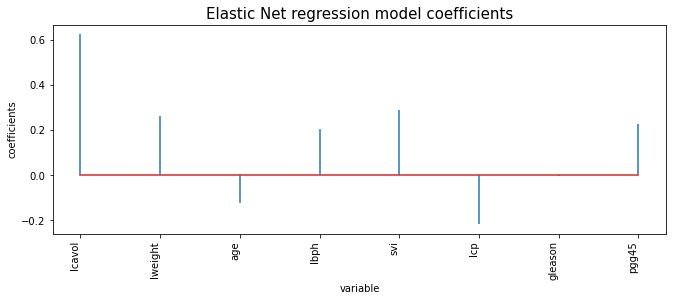

In [54]:
plot_model_coefficients(X_train, eln_coeff, "Elastic Net regression")

In [16]:
train_scores, val_scores = validation_curve(ElasticNet(l1_ratio=0.5),
                                  X_train, y_train, param_name="alpha", param_range=alphas,
                                  cv=10, scoring='neg_mean_squared_error')
train_scores = -(train_scores)
val_scores = -(val_scores)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

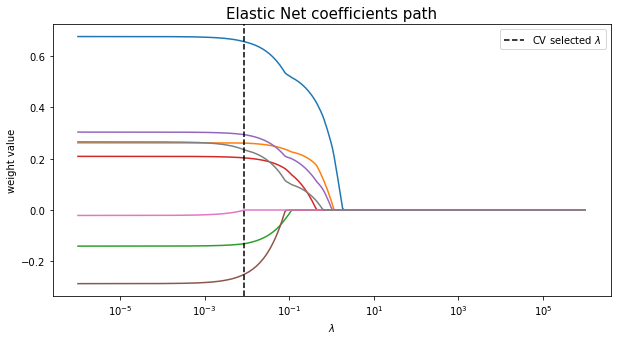

In [17]:
plot_paths(alphas, val_mean, coef_eln, 'Elastic Net')  #holding l1_ratio at 0.5

In [53]:
#THIS CHECK THAT THE MSE CURVE IS FLAT AFTER SOME THRESHOLD. sO THERE ARE SEVERAL ALPHAS THAT YIELDS THE SAME MSE.
#THEREFORE THE ELNET PLOT (TUNING L1_RATIO=0) SCENARIO WILL BE THE SAME AS RIDGE

train_scores, val_scores = validation_curve(ElasticNet(l1_ratio=0),
                                  X_train, y_train, param_name="alpha", param_range=alphas,
                                  cv=10, scoring='neg_mean_squared_error')
train_scores = -(train_scores)
val_scores = -(val_scores)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plot_CV(val_scores, val_mean)

TypeError: plot_CV() missing 1 required positional argument: 'val_mean'

# Model selection

In [114]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

#Lasso is more parsimonious but there is likely to be a loss of accuracy.
#Elastic net is a good trade-off for accuracy and computational cost balance between the Ridge regression and the Lasso.

Linear regression error:   0.5213
Minimun ridge error:       0.4859
Minimum lasso error:       0.4525
Minimum elastic net error: 0.4615


In [75]:
#using cross-validation
print("Linear regression test MSE:   %0.4f" % baseline_error)    
print("ridge test MSE:       %0.4f" % (pred_err_ridge_gs))
print("lasso test MSE:       %0.4f" % (pred_err_lasso_gs))
print("elastic net test MSE: %0.4f" % (pred_err_elnet_gs))

Linear regression test MSE:   0.5213
ridge test MSE:       0.5043
lasso test MSE:       0.5112
elastic net test MSE: 0.5043
